In [1]:
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import scipy.stats as scs
import emcee

## Functions

In [2]:
def mcmc_maximize(logfun, x0, args, **kwargs):
    """
    Maximize a pdf given as log(prob).

    Parameters
    ----------
    logfun : function
        Logarithm of a pdf, taking an n-dim input vector and returning a scalar
    x0 : array-like
        Initial guess values for the maximization for each dimension
    args : tuple
        Additonal parameters passed to ``logfun``. Call signature is
        ``logfun(x, *args)``

    kwargs
    ------
    nwalkers : int
        Even number of walkers per dimension for the MCMC implementation
    niter : int
        Number of random samples drawn in each MCMC sample step
    maxiter : int
        Maximum number of iterations to find the minimum. Total samples drawn
        by the MCMC sampler are niter * maxiter
    rel_eps : float
        Precision to which the minimum position is calculated

    Returns
    -------
    res : dictionary
        scipy.minimize result dict
    """
    x0 = np.atleast_1d(x0)
    ndim = len(x0)

    nwalkers = kwargs.pop("nwalkers", 4 * ndim)
    niter = kwargs.pop("niter", 100 * ndim)
    maxiter = kwargs.pop("maxiter", 50)
    rel_eps = kwargs.pop("rel_eps", 1.e-5)

    # Create starting point for each walker in a gaussian ball around x0
    mean = x0
    cov = mean / (0.1 * np.sqrt(np.abs(mean)))
    p0 = np.random.normal(mean=mean, cov=cov).reshape((nwalkers, ndim))

    sampler = emcee.EnsembleSampler(
        nwalkers=nwalkers, dim=ndim, lnpostfn=logfun)

    def neglogfun(x, *args):
        """Define the negative function for the classic minimizer"""
        return -1. * logfun(x, *args)
    
    # Save all minimizer results
    res = []
    
    # Generate seed point for classic minimizer via MCMC until the minimum
    # converges between iterations
    for i in range(maxiter):
        # First run MCMC and get a minimum
        p0, _, _ = sampler.run_mcmc(pos0=p0, N=niter)
        lnprob = np.append(lnprob, sampler.flatlnprobability)
        min_idx = np.argmin(lnprob)
        xmin = sampler.flatchain[min_idx]
        
        # Then ue a classic fitter with the MCMC minimum as a seed
        res.append(sco.minimize(fun=neglogfun, x0=p0, args=args))
        
        if terminate(res, rel_eps):
            break
    return res, i, lnprob, sampler.flatchain

def terminate(res, rel_eps):
    """"
    Returns True if a given termination condition is matched, otherwise
    returns False.
    
    Parameters
    ----------
    res : list
        Hold the OptimizeObjects from every iteration
    rel_eps : float
        Precision to which the minimum position is calculated
    """
    if len(res) < 2:
        return False
        
    res_cur = res[-1].x
    res_prev = res[-2].x
    
    if (np.any(np.abs(res_cur) < rel_eps) or
        np.any(np.abs(res.prev) < rel_eps)):
        cond = np.abs(res_cur - res_prev) < rel_eps
    else:
        cond = np.abs(res_cur / res_prev) < rel_eps
    
    return cond

In [3]:
def log_double_gaus(x, mu, sigma):
    """
    Each gaussian contributes equally
    
    x : array
        2D array with shape (npoint, len(mu))
    """
    x = np.atleast_1d(x)
    x = x.reshape(len(x), 1).repeat(len(mu), axis=1)
    return np.log(np.sum(scs.norm.pdf(x, mu, sigma), axis=1) / len(mu))

In [6]:
def neglogllh(par, args):
    """
    Negative log-likelihood of the double peak gaussian
    
    Parameters
    ----------
    par : array-like
        First half are mu values, second half are sigma values
    args : tupel
        args(0) is the array with the sample points x
        
    Returns
    -------
    neglhh : float
        Negative log-likelihood value for the given sample points and paramters
    """
    ndim = len(par)
    mu, sigma = par[:ndim//2], par[ndim//2:]
    xis = args[0]
    
    negllh = -1. * np.sum(log_double_gaus(xis, mu, sigma))
    return negllh

In [4]:
def double_gaus_sample(mu, sigma, nevts):
    idx = np.random.choice(range(len(mu)), size=nevts)
    mus = mu[idx]
    sigmas = sigma[idx]
    
    sample = np.random.normal(mus, sigmas)
    return sample

## Testdata and scans

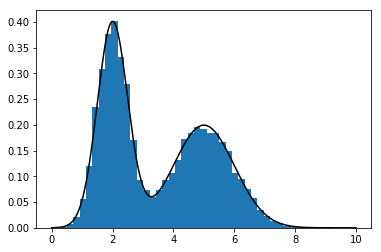

In [5]:
# Setup 2 peaks
mu = np.array([2, 5])
sigma = np.array([.5, 1.])

# Scan pdf
x = np.linspace(0, 10, 1000)
y = np.exp(log_double_gaus(x, mu, sigma))
    
# Sample
sample = double_gaus_sample(mu, sigma, 10000)

plt.hist(sample, bins=40, normed=True);
plt.plot(x, y, "k-");

In [7]:
# Do a LLH scan in mu1, mu2 space around true sigma
mu1 = np.linspace(-2, 12)
mu2 = np.linspace(-2, 12)
mu1, mu2 = np.meshgrid(mu1, mu2)

MU1 = mu1.flatten()
MU2 = mu2.flatten()

z = np.zeros_like(MU1)

for i, (mu1i, mu2i) in enumerate(zip(MU1, MU2)):
    mui = np.array([mu1i, mu2i])
    z[i] = neglogllh(np.append(mui, sigma), (sample,))
    
z = z.reshape(mu1.shape)

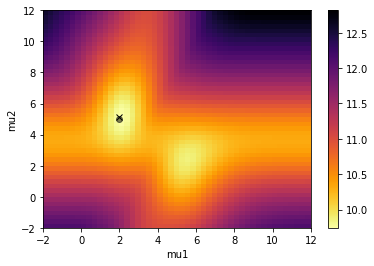

In [8]:
# Plot landscape and scan + true minimum
plt.pcolormesh(mu1, mu2, np.log(z), cmap="inferno_r");
plt.colorbar();

min_idx = np.argmin(z[::1])
plt.plot(MU1[min_idx], MU2[min_idx], "kx")
plt.plot(mu[0], mu[1], "ko", alpha=0.5)

plt.xlabel("mu1")
plt.ylabel("mu2")

In [9]:
# Do a LLH scan in sigma1, sigma2 space around true mu
sigma1 = np.linspace(0.1, 4)
sigma2 = np.linspace(0.1, 4)
sigma1, sigma2 = np.meshgrid(sigma1, sigma2)

SIGMA1 = sigma1.flatten()
SIGMA2 = sigma2.flatten()

z_sig = np.zeros_like(SIGMA1)

for i, (sigma1i, sigma2i) in enumerate(zip(SIGMA1, SIGMA2)):
    sigmai = np.array([sigma1i, sigma2i])
    z_sig[i] = neglogllh(np.append(mu, sigmai), (sample,))
    
z_sig = z_sig.reshape(sigma1.shape)

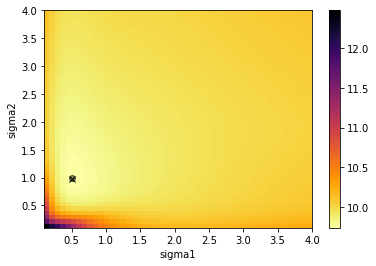

In [40]:
# Plot landscape and scan + true minimum
plt.pcolormesh(sigma1, sigma2, np.log(z_sig), cmap="inferno_r");
plt.colorbar();

min_idx = np.argmin(z_sig)
plt.plot(SIGMA1[min_idx], SIGMA2[min_idx], "kx")
plt.plot(sigma[0], sigma[1], "ko", alpha=0.5)

plt.xlabel("sigma1")
plt.ylabel("sigma2")

## Fit tests

In [37]:
mu0 = np.random.uniform(0, 10, 2 * 100).reshape(100, 2)
sigma0 = np.random.uniform(0.1, 4, 2 * 100).reshape(100, 2)

res = []

bounds = [[None, None], [None, None], [0.1, None], [0.1, None]]

for i, (mui, sigi) in enumerate(zip(mu0, sigma0)):
    res.append(sco.minimize(
            neglogllh, np.concatenate((mui, sigmai)), args=(sample), bounds=bounds))

/Users/tmenne/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


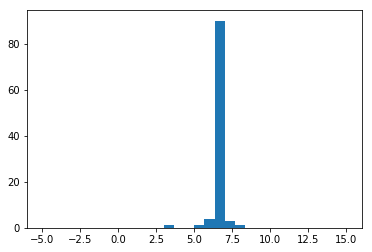

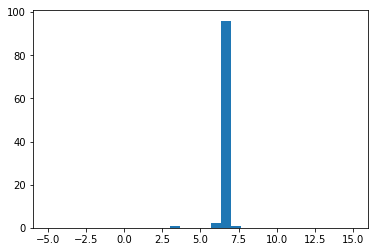

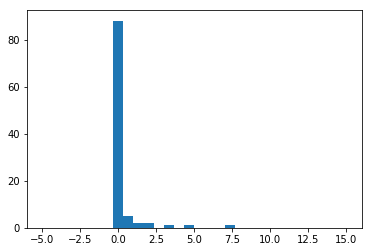

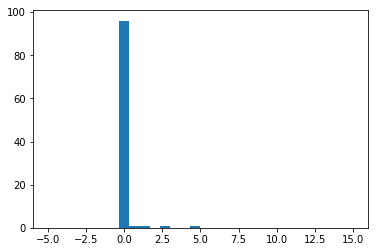

In [38]:
min_samples = np.array([resi.x for resi in res])

for var_sam in min_samples.T:
    plt.hist(var_sam, bins=30, range=[-5, 15])
    plt.show()